In [166]:
import numpy as np
import pandas as pd
import pandas.io.sql as psql
from pandas import ExcelWriter
from pandas import ExcelFile
import openpyxl
pd.options.mode.chained_assignment = None

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn import model_selection, linear_model
from sklearn.feature_selection import RFE

from statsmodels.regression.linear_model import OLS, OLSResults
import statsmodels.api as sm


plt.style.use("ggplot")


In [167]:
performance_2019 = pd.read_excel('../../capstone2/data/2019_sales_by_month.xlsx')
performance_2019.head()

Property Name Property Code  Brand  \
0                     Hilton Garden Inn Times Square         NYCMW  Hilto   
1                       InterContinental New Orleans         MSYHA  Inter   
2  DoubleTree Suites by Hilton Hotel Boston - Cam...         BOSSB  Doubl   
3    Hilton Garden Inn New Orleans Convention Center         MSYGI  Hilto   
4          Crowne Plaza Fredericton-Lord Beaverbrook         YFCQS  Crown   

   #Rooms             Management Company Registration Date Activation Date  \
0   369.0          Highgate Hotels, Inc.        2017-10-06      2017-10-27   
1   484.0  Dimension Development Company        2018-08-17      2018-09-20   
2   308.0               Hilton Worldwide        2018-04-10      2018-06-11   
3   286.0  Interstate Hotels and Resorts        2018-06-27      2018-09-04   
4   169.0             IHG - Crowne Plaza        2018-09-26      2019-02-11   

      Last Transaction   Revenue  Profit Margin  Gross Profit  Pend Prod  \
0  2019-02-01 03:49:00  48190.59        0.72970      35164.64       76.0   
1  2019-02-01 05:39:00  22829.80        0.67301      15364.72       69.0   
2  2019-02-01 04:58:00  22488.70        0.69884      15715.96       36.0   
3  2019-02-01 05:52:00  15917.05        0.84608      13467.05      142.0   
4  2019-03-01 03:58:00    544.45        0.56147        305.69        NaN   

   Neg Inv  Low Prod Sales  Shift Rep Days  PMS Port              Column1  \
0    119.0             NaN     a long time   35010.0  Details Use Archive   
1     86.0            99.0        6 months    5011.0  Details Use Archive   
2    165.0             NaN        6 months   35010.0  Details Use Archive   
3    239.0             NaN          7 days   35010.0  Details Use Archive   
4      1.0             NaN  about 21 hours    5011.0  Details Use Archive   

  Month of Reporting  
0            January  
1            January  
2            January  
3            January  
4           February

In [168]:
#drop NaN, drop unwanted columns, create additional column 'Flag'
cleaning_df = performance_2019.dropna(subset=['Property Code'])
cleaning_df.drop(['Column1', 'Pend Prod', 'Neg Inv', 'Low Prod Sales', 'Shift Rep Days', 'PMS Port', 'Last Transaction', 'Registration Date', 'Management Company'], axis=1, inplace=True)
cleaning_df['Flag']=cleaning_df['Brand']

In [169]:
#replace month strings with int
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
value = 1
for month in months:
    cleaning_df.replace(to_replace=month, value=value, inplace=True)
    value+=1

In [188]:
#clean up brand field 
cleaning_df['Brand'].replace(to_replace=['Tru B', 'TRU B', 'TRU b', 'Tru b', 'Home2', 'Homew', 'The S', 'Hampt', 'Doubl', 'Embas', 'Miram'], value='Hilto', inplace=True)
cleaning_df['Brand'].replace(to_replace=['Stayb', 'Inter', 'IHG A', 'Holid', 'Avid ', 'Crown', 'Candl'], value='IHG', inplace=True)
cleaning_df['Brand'].replace(to_replace= ['Aston', 'Delta', 'Renai'], value='Marri', inplace=True)
cleaning_df['Brand'].replace(to_replace= ['Quali', 'Comfo'], value='Choic', inplace=True)
cleaning_df['Brand'].replace(to_replace= 'La Quin', value='Wyndh', inplace=True)
cleaning_df['Brand'].replace(to_replace= ['Blueb', 'River'], value='Apart', inplace=True)
cleaning_df['Brand'].replace(to_replace= ['Platt'], value='Impul', inplace=True)
cleaning_df['Brand'].replace(to_replace= ['Hammo'], value='Indep', inplace=True)

arr = ['LAXMA', 'LGBMY']
prop_mask1 = cleaning_df['Property Code'].isin(arr) 
cleaning_df['Brand'][prop_mask1] = 'Hilto'
prop_mask2 = cleaning_df['Property Code'] == 'IHG - ATLID'
cleaning_df['Brand'][prop_mask2] = 'IHG'

In [209]:
#flag masking for sub-brands
arr = ['LAXMA', 'LGBMY']
prop_mask1 = cleaning_df['Property Code'].isin(arr) 
cleaning_df['Flag'][prop_mask1] = 'Hilto'


In [215]:
test_mask = cleaning_df['Flag'] == 'Hampton'
test_df = cleaning_df[test_mask]
test_df['Property Code'].unique()

array(['NYCFF', 'LAXEL', 'INDDT', 'PITDN', 'DENCV', 'PDXHR', 'BALCO',
       'OTHRO', 'SYRNA', 'AVLTU', 'AVLBA', 'PBIJB', 'MCOCC', 'DCANY',
       'YRKPA', 'BLHBL', 'AVLAP', 'LAXBK', 'TIXFL', 'TPATS', 'LAXGL',
       'ONHNJ', 'PLMHS', 'PSLWE', 'BTRDN', 'CHIMC', 'STLGA', 'ALOIA',
       'RIWWY', 'DENAP', 'RAPHA', 'WASFB', 'CSGPC', 'VSKTC', 'JAXOR',
       'MCOSW', 'CRWSO', 'HRBPA', 'EUFHX', 'FTWTC', 'HDSNC', 'YQFRD',
       'SRCSP', 'MLTNY', 'WASAL', 'FLLMM', 'MTJCO', 'ATLSV', 'LNKNH',
       'LAXGL-BAR', 'WNCVA', 'AGOSN', 'SEADP', 'LJNCL', 'BHMRC', 'WBUGB',
       'HOUST', 'ATLPS', 'YXEAP', 'FSDSW', 'LNSGF', 'INDPF', 'RDUCL',
       'ALBAP', 'GSOEA', 'HKYBO', 'DULMN', 'LGAYW', 'SLNKS', 'CFORD',
       'MCOLV', 'RSTNO', 'RAPRC', 'SEANP', 'TULPR', 'YYZHS', 'ARTNY',
       'AUSDT', 'ABEKZ', 'OAKDC', 'CHALM', 'SNAIO', 'NYCLA', 'ILMDO',
       'PHXEM', 'WASHH', 'AVLMO', 'CHIWX', 'ARXNP'], dtype=object)

In [190]:
#clean up flag field
cleaning_df['Flag'].replace(to_replace=['TRU B', 'TRU b', 'Tru B', 'Tru b'], value='Tru by Hilton', inplace=True)
# cleaning_df['Flag'].replace(to_replace= 'Hilto', value='Hilton', inplace=True)
# cleaning_df['Flag'].replace(to_replace= 'Hampt', value='Hampton', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'The S', value='Tapestry Collections', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Homew', value='Homewood Suites by Hilton', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Home2', value='Home2 Suites by Hilton', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'The S', value='Tapestry Collections', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Holid', value='Holiday Inn', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Stayb', value='Staybridge Suites', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Crown', value='Crowne Plaza', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Embas', value='Embassy Hilton', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Doubl', value='DoubleTree by Hilton', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Candl', value='Candlewood Suites', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Avid ', value='Avid', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Comfo', value='Comfort Suites', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Quali', value='Quality Suites', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'IHG A', value='IHG Army Hotels', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'La Quinta', value='La Quinta Inn & Suites', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Inter', value='Intercontinental Hotels', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Renai', value='Renaissance', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Delta', value='Delta Hotels', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Best ', value='Best Western Plus', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Miram', value='Curio Collection', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Hammo', value='Independant', inplace=True)
cleaning_df['Flag'].replace(to_replace=['Blueb', 'River'], value='Apartment Complex', inplace=True)
cleaning_df['Flag'].replace(to_replace= 'Platt', value='Retail', inplace=True)

In [191]:
unique_brands = cleaning_df['Brand'].unique()
print(cleaning_df['Brand'].value_counts())
print(unique_brands)

Hilto    3967
IHG       467
Choic      23
Marri      19
Apart      12
La Qu      12
Best        4
Indep       1
Impul       1
Name: Brand, dtype: int64
['Hilto' 'IHG' 'La Qu' 'Choic' 'Marri' 'Apart' 'Best ' 'Impul' 'Indep']


In [192]:
#drop all hotels with activation date after 2019-01-01
age_mask = cleaning_df['Activation Date'] <= '2019-01-01'

#drop all hotels wtih a profit margin > 0.74 or < 0.44
high_profit_mask = cleaning_df['Profit Margin'] < 0.74
low_profit_mask = cleaning_df['Profit Margin'] > 0.44
drop_masks = cleaning_df[age_mask & high_profit_mask & low_profit_mask].copy()
drop_masks['Brand'].value_counts()

Hilto    2316
IHG       204
La Qu      12
Choic      11
Marri       7
Name: Brand, dtype: int64

In [193]:
#create a list of brands with low reporting
drop_brands = []
for brand in unique_brands:
    drop_brand_count = drop_masks[drop_masks['Brand'] == brand]
    if len(drop_brand_count) <= 12:
        drop_brands.append(brand)

print(drop_brands)
#drop all brands with less than 12 months reported

low_count_mask = ~drop_masks['Brand'].isin(drop_brands)

dropped_everything = drop_masks[low_count_mask].copy()
dropped_everything['Brand'].value_counts()

['La Qu', 'Choic', 'Marri', 'Apart', 'Best ', 'Impul', 'Indep']


Hilto    2316
IHG       204
Name: Brand, dtype: int64

In [194]:
#create feature columns for Brands
drop_masks['is_hilton'] = drop_masks['Brand'] == 'Hilto'
drop_masks['is_IHG'] = drop_masks['Brand'] == 'IHG'
drop_masks['is_la_quinta'] = drop_masks['Brand'] == 'La Qu'
drop_masks['is_choice'] = drop_masks['Brand'] == 'Choic'
drop_masks['is_marriott'] = drop_masks['Brand'] == 'Marri'

drop_masks.replace(to_replace= [True, False], value=[1, 0], inplace=True)
drop_masks

Property Name Property Code  Brand  \
0                        Hilton Garden Inn Times Square         NYCMW  Hilto   
1                          InterContinental New Orleans         MSYHA    IHG   
2     DoubleTree Suites by Hilton Hotel Boston - Cam...         BOSSB  Hilto   
5                             Crowne Plaza Lansing West         LANCP    IHG   
6            Homewood Suites Savannah Historic District         SAVRB  Hilto   
...                                                 ...           ...    ...   
4477                               Hampton Inn Magnolia         AGOSN  Hilto   
4481                Tru by Hilton Bryan College Station         CLLCS  Hilto   
4487                    Comfort Suites Downtown Orlando         FL094  Choic   
4498                        Hampton Inn Greensboro-East         GSOEA  Hilto   
4502                     Hilton Garden Inn Wilkes Barre         AVPWI  Hilto   

      #Rooms Activation Date   Revenue  Profit Margin  Gross Profit  \
0      369.0      2017-10-27  48190.59        0.72970      35164.64   
1      484.0      2018-09-20  22829.80        0.67301      15364.72   
2      308.0      2018-06-11  22488.70        0.69884      15715.96   
5      212.0      2018-10-26    611.00        0.60129        367.39   
6      162.0      2018-04-10  14439.60        0.63231       9130.27   
...      ...             ...       ...            ...           ...   
4477    68.0      2018-04-03    835.85        0.60038        501.83   
4481    98.0      2018-08-27    809.84        0.67184        544.08   
4487   122.0      2017-07-13    762.75        0.58116        443.28   
4498    78.0      2018-09-29    614.38        0.54211        333.06   
4502   123.0      2015-06-02    563.39        0.61661        347.39   

      Month of Reporting                       Flag  is_hilton  is_IHG  \
0                      1                     Hilton          1       0   
1                      1    Intercontinental Hotels          0       1   
2                      1       DoubleTree by Hilton          1       0   
5                      4               Crowne Plaza          0       1   
6                      1  Homewood Suites by Hilton          1       0   
...                  ...                        ...        ...     ...   
4477                  12                    Hampton          1       0   
4481                  12              Tru by Hilton          1       0   
4487                  12             Comfort Suites          0       0   
4498                  12                    Hampton          1       0   
4502                  12                     Hilton          1       0   

      is_la_quinta  is_choice  is_marriott  
0                0          0            0  
1                0          0            0  
2                0          0            0  
5                0          0            0  
6                0          0            0  
...            ...        ...          ...  
4477             0          0            0  
4481             0          0            0  
4487             0          1            0  
4498             0          0            0  
4502             0          0            0  

[2550 rows x 15 columns]

In [195]:
#create SPOR column for the year by month
avg_occupancy = 0.68 #industry average
SPOR = [drop_masks['Revenue']/(drop_masks['#Rooms']*30.62*avg_occupancy)]
SPOR_df = pd.DataFrame(SPOR).transpose()

drop_masks['SPOR'] = SPOR_df
test_hotels = drop_masks.copy()
# drop more columns
test_hotels.drop(['Activation Date', 'Flag'], axis=1, inplace=True)
test_hotels['Brand'].value_counts()

Hilto    2316
IHG       204
La Qu      12
Choic      11
Marri       7
Name: Brand, dtype: int64

In [196]:
rev_and_profit_columns = ['#Rooms', 'Revenue', 'Profit Margin', 'Gross Profit', 'SPOR']
rev_and_profit_df = test_hotels[rev_and_profit_columns].copy()

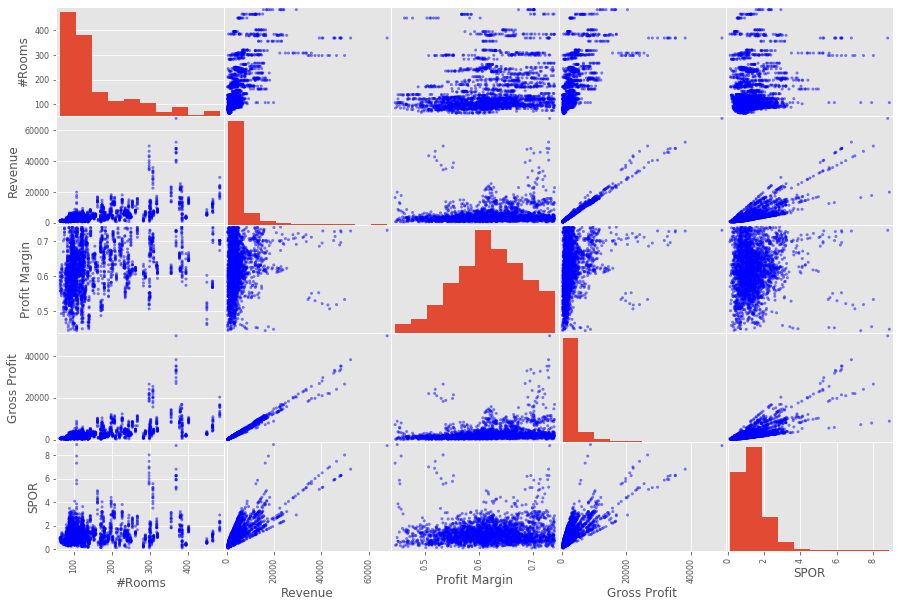

<Figure size 432x288 with 0 Axes>

In [197]:
pd.plotting.scatter_matrix(rev_and_profit_df, figsize=(15, 10), color = 'b')
plt.show()
plt.savefig('../images/revenue_and_profit_scatter_matrix.png')

In [198]:
test_subset = ['Property Name', 'Brand', '#Rooms', 'Revenue', 'Profit Margin', 'Gross Profit', 'Month of Reporting', 'SPOR', 'is_hilton', 'is_IHG', 'is_la_quinta', 'is_choice', 'is_marriott']
test_rev_columns = ['#Rooms', 'Revenue', 'Profit Margin', 'Gross Profit', 'SPOR', 'is_hilton', 'is_IHG', 'is_la_quinta', 'is_choice', 'is_marriott']
test_df = test_hotels[test_subset].copy()
test_rev_df = test_hotels[test_rev_columns].copy
test_rev_df

# m0 = test_df['Month of Reporting'] == 12
# m1 = test_df['Month of Reporting'] != 12

<bound method NDFrame.copy of       #Rooms   Revenue  Profit Margin  Gross Profit      SPOR  is_hilton  \
0      369.0  48190.59        0.72970      35164.64  6.272227          1   
1      484.0  22829.80        0.67301      15364.72  2.265388          0   
2      308.0  22488.70        0.69884      15715.96  3.506707          1   
5      212.0    611.00        0.60129        367.39  0.138418          0   
6      162.0  14439.60        0.63231       9130.27  4.280811          1   
...      ...       ...            ...           ...       ...        ...   
4477    68.0    835.85        0.60038        501.83  0.590344          1   
4481    98.0    809.84        0.67184        544.08  0.396880          1   
4487   122.0    762.75        0.58116        443.28  0.300267          0   
4498    78.0    614.38        0.54211        333.06  0.378293          1   
4502   123.0    563.39        0.61661        347.39  0.219983          1   

      is_IHG  is_la_quinta  is_choice  is_marriott  
0   

In [199]:
# m0 = hilton_performance_2019_subset['Month of Reporting'] == 12
# m1 = hilton_performance_2019_subset['Month of Reporting'] != 12

# y_train = hilton_performance_2019_subset[m1].pop('SPOR').values
# X_train = hilton_rev_columns[m1].values
# y_test = hilton_performance_2019_subset[m0].pop('SPOR').values
# X_test = hilton_rev_columns[m0].values